In [1]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Qiskit
from qiskit import IBMQ

# Local modules
from utilities import startup, check_provider
from graphstate import GraphState, calc_negativities, plot_negativities_multi, calc_n_mean, plot_cxerr_corr

provider = startup()

Account enabled
Provider: ibm-q-melbourne


In [2]:
check_provider()

ibmq_montreal has 365 queud and 27 qubits
ibmq_toronto has 17 queud and 27 qubits
ibmq_kolkata has 78 queud and 27 qubits
ibmq_mumbai has 8 queud and 27 qubits
ibmq_lima has 119 queud and 5 qubits
ibmq_belem has 7 queud and 5 qubits
ibmq_quito has 19 queud and 5 qubits
ibmq_guadalupe has 142 queud and 16 qubits
ibmq_jakarta has 5 queud and 7 qubits
ibmq_manila has 20 queud and 5 qubits
ibm_hanoi has 155 queud and 27 qubits
ibm_lagos has 634 queud and 7 qubits
ibm_nairobi has 21 queud and 7 qubits
ibm_cairo has 365 queud and 27 qubits
ibm_auckland has 780 queud and 27 qubits
ibm_perth has 21 queud and 7 qubits
ibm_washington has 118 queud and 127 qubits
ibm_oslo has 29 queud and 7 qubits
ibm_geneva has 21 queud and 27 qubits


In [2]:
import networkx as nx

def get_negativity_info(n_list, nmit_list):
    
    n_mean_dict, _ = calc_n_mean(n_list)
    n_mean = np.mean(list(n_mean_dict.values()))
    std = np.std(list(n_mean_dict.values()))

    nmit_mean_dict, _ = calc_n_mean(nmit_list)
    nmit_mean = np.mean(list(nmit_mean_dict.values()))
    std_mit = np.std(list(nmit_mean_dict.values()))
    
    n5 = get_largest_connected(n_mean_dict, threshold=0.025)
    n50 = get_largest_connected(n_mean_dict, threshold=0.25)
    n75 = get_largest_connected(n_mean_dict, threshold=0.75*0.5)
    n90 = get_largest_connected(n_mean_dict, threshold=0.9*0.5)
    
    nmit5 = get_largest_connected(nmit_mean_dict, threshold=0.025)
    nmit50 = get_largest_connected(nmit_mean_dict, threshold=0.25)
    nmit75 = get_largest_connected(nmit_mean_dict, threshold=0.75*0.5)
    nmit90 = get_largest_connected(nmit_mean_dict, threshold=0.9*0.5)
    
    info_dict = {'Mean negativity': n_mean,
                 'std': std,
                'Mean negativity (mit)': nmit_mean,
                 'std (mit)': std_mit,
                'Connected N>5%': len(n5),
                'Connected N>50%': len(n50),
                'Connected N>75%': len(n75),
                'Connected N>90%': len(n90),
                'Connected N>5% (mit)': len(nmit5),
                'Connected N>50% (mit)': len(nmit50),
                'Connected N>75% (mit)': len(nmit75),
                'Connected N>90% (mit)': len(nmit90)}

    return info_dict

def get_largest_connected(n_dict, threshold=0.25):
    
    edges = filter_edges(n_dict, threshold)
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        largest = max(nx.connected_components(G), key=len)
    except:
        largest = {}
    
    return largest
    
def filter_edges(n_dict, threshold=0.25/2):
    return [key for key, value in n_dict.items() if value >= threshold]

def get_mean_cnot(graphstate, properties):
    err_array = np.zeros(len(graphstate.edge_list))
    for i, edge in enumerate(graphstate.edge_list):
        err = properties.gate_error('cx', edge)
        if err < 0.9:
            err_array[i] = err
        #print(edge, err_array[i])
    
    return np.mean(err_array), np.std(err_array)

### Negativity Calculation and Plotting

In [3]:
n_mean_list = []
n_std_list = []
nmit_mean_list = []
nmit_std_list = []
err_mean = []
err_std = []
device = []

In [120]:
plt.rc('font', size=12.5)

#### ibmq_lima

In [9]:
backend = provider.get_backend('ibmq_lima')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_lima (5 qubits)
Job 1 ID: 62e0854f3bc04172e4fd6c37
Job 2 ID: 62e085533bc0415ea8fd6c38


In [121]:
time0 = time()
backend = provider.get_backend('ibmq_lima')
job1 = backend.retrieve_job('62e0854f3bc04172e4fd6c37')
job2 = backend.retrieve_job('62e085533bc0415ea8fd6c38')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 5.88 s


{'Mean negativity': 0.3253637101290425,
 'std': 0.03203552972394254,
 'Mean negativity (mit)': 0.46169068506182925,
 'std (mit)': 0.010788159079027049,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

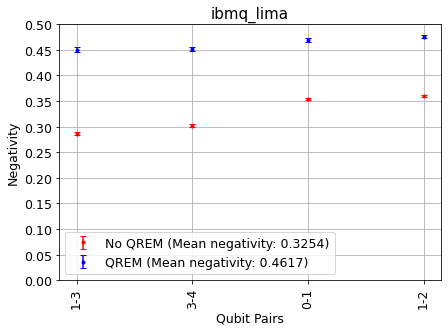

In [122]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibmq_belem

In [15]:
backend = provider.get_backend('ibmq_belem')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_belem (5 qubits)
Job 1 ID: 62debd33c2d082cf7108c178
Job 2 ID: 62debd371813981decc6cb22


In [123]:
time0 = time()
backend = provider.get_backend('ibmq_belem')
job1 = backend.retrieve_job('62debd33c2d082cf7108c178')
job2 = backend.retrieve_job('62debd371813981decc6cb22')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.52 s


{'Mean negativity': 0.2761372590655869,
 'std': 0.024303949882431543,
 'Mean negativity (mit)': 0.41169341741067567,
 'std (mit)': 0.013987133445600018,
 'Connected N>5%': 5,
 'Connected N>50%': 3,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 0}

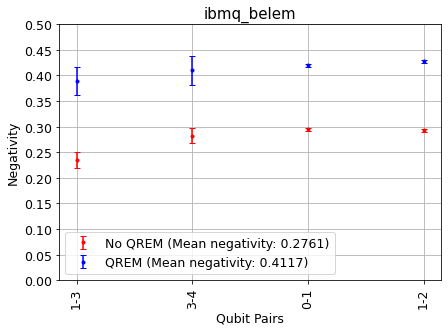

In [124]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibmq_quito

In [5]:
backend = provider.get_backend('ibmq_quito')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_quito (5 qubits)
Job 1 ID: 62e083cc22b5f5c9d5565888
Job 2 ID: 62e083d1c2d4972bd5e36bec


In [125]:
time0 = time()
backend = provider.get_backend('ibmq_quito')
job1 = backend.retrieve_job('62e083cc22b5f5c9d5565888')
job2 = backend.retrieve_job('62e083d1c2d4972bd5e36bec')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 4.01 s


{'Mean negativity': 0.2690744692124989,
 'std': 0.025957757034238128,
 'Mean negativity (mit)': 0.4717283057903344,
 'std (mit)': 0.004948237938112237,
 'Connected N>5%': 5,
 'Connected N>50%': 3,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

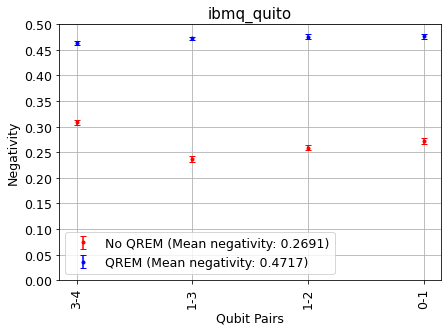

In [126]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibmq_manila

In [17]:
backend = provider.get_backend('ibmq_manila')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_manila (5 qubits)
Job 1 ID: 62debdad9ef0519cc8768fb4
Job 2 ID: 62debdb11813981a54c6cb2a


In [127]:
time0 = time()
backend = provider.get_backend('ibmq_manila')
job1 = backend.retrieve_job('62debdad9ef0519cc8768fb4')
job2 = backend.retrieve_job('62debdb11813981a54c6cb2a')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.37 s


{'Mean negativity': 0.3680974256499723,
 'std': 0.02026249150100633,
 'Mean negativity (mit)': 0.4789777658340744,
 'std (mit)': 0.006402110619405756,
 'Connected N>5%': 5,
 'Connected N>50%': 5,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 5,
 'Connected N>50% (mit)': 5,
 'Connected N>75% (mit)': 5,
 'Connected N>90% (mit)': 5}

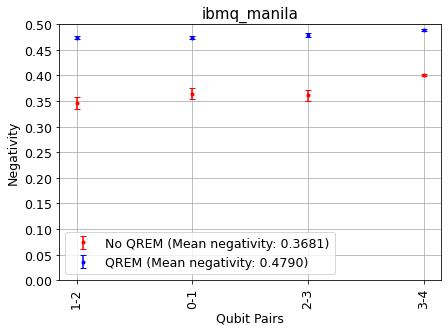

In [128]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibmq_jakarta

In [4]:
backend = provider.get_backend('ibmq_jakarta')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_jakarta (7 qubits)
Job 1 ID: 62e0bea3c2d497582ee36c59
Job 2 ID: 62e0beb28fc0975ff00a868f


In [129]:
time0 = time()
backend = provider.get_backend('ibmq_jakarta')
job1 = backend.retrieve_job('62e0bea3c2d497582ee36c59')
job2 = backend.retrieve_job('62e0beb28fc0975ff00a868f')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.76 s


{'Mean negativity': 0.27736995662936365,
 'std': 0.032952485573451,
 'Mean negativity (mit)': 0.4684761521074656,
 'std (mit)': 0.011609854514432003,
 'Connected N>5%': 7,
 'Connected N>50%': 3,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 4}

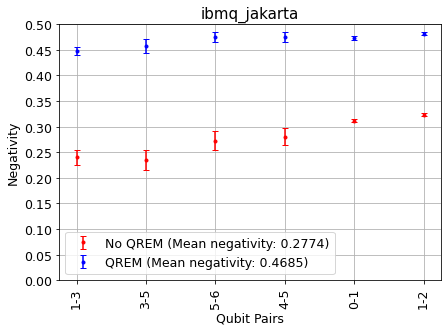

In [130]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_oslo

In [10]:
backend = provider.get_backend('ibm_oslo')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_oslo (7 qubits)
Job 1 ID: 62e085925593a8ab36192710
Job 2 ID: 62e08599fb9fa11c75a31beb


In [131]:
time0 = time()
backend = provider.get_backend('ibm_oslo')
job1 = backend.retrieve_job('62e085925593a8ab36192710')
job2 = backend.retrieve_job('62e08599fb9fa11c75a31beb')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.86 s


{'Mean negativity': 0.38052011002690067,
 'std': 0.017966811390710113,
 'Mean negativity (mit)': 0.47678810264766974,
 'std (mit)': 0.01213389527943529,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 4,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

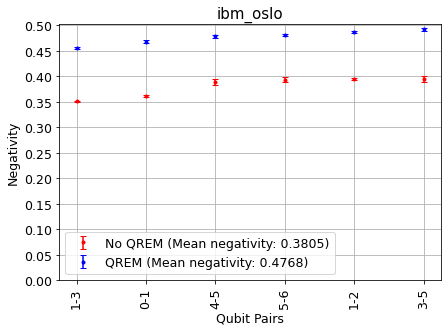

In [132]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_nairobi

In [58]:
backend = provider.get_backend('ibm_nairobi')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_nairobi (7 qubits)
Job 1 ID: 633859475706bc52c04659b4
Job 2 ID: 6338594f5706bca0ab4659b5


In [133]:
time0 = time()
backend = provider.get_backend('ibm_nairobi')
job1 = backend.retrieve_job('633859475706bc52c04659b4')
job2 = backend.retrieve_job('6338594f5706bca0ab4659b5')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.78 s


{'Mean negativity': 0.34769647571983403,
 'std': 0.014219340130703693,
 'Mean negativity (mit)': 0.4791458489597016,
 'std (mit)': 0.0049007106931319684,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

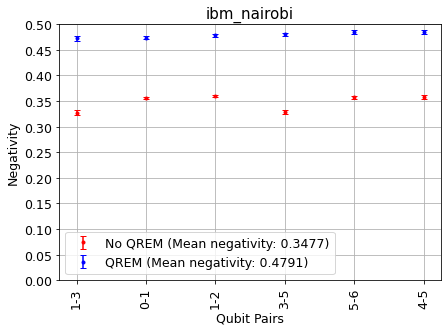

In [134]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_lagos

In [12]:
backend = provider.get_backend('ibm_lagos')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_lagos (7 qubits)
Job 1 ID: 62e085de3bc0414613fd6c39
Job 2 ID: 62e085e4c2d497f25fe36bee


In [135]:
time0 = time()
backend = provider.get_backend('ibm_lagos')
job1 = backend.retrieve_job('62e085de3bc0414613fd6c39')
job2 = backend.retrieve_job('62e085e4c2d497f25fe36bee')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.71 s


{'Mean negativity': 0.3579290428433304,
 'std': 0.025892403309026417,
 'Mean negativity (mit)': 0.45408052748002287,
 'std (mit)': 0.01122958313604215,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 3,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 3}

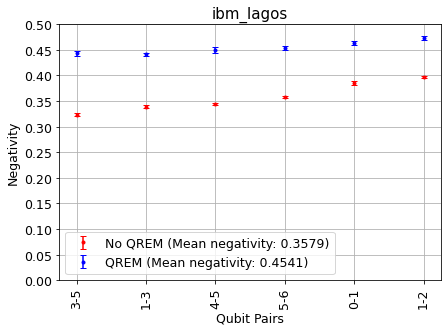

In [136]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_perth

In [13]:
backend = provider.get_backend('ibm_perth')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_perth (7 qubits)
Job 1 ID: 62e086025923b654835f3fbe
Job 2 ID: 62e086095923b634015f3fbf


In [137]:
time0 = time()
backend = provider.get_backend('ibm_perth')
job1 = backend.retrieve_job('62e086025923b654835f3fbe')
job2 = backend.retrieve_job('62e086095923b634015f3fbf')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 3.96 s


{'Mean negativity': 0.32769727380550806,
 'std': 0.01854400747547054,
 'Mean negativity (mit)': 0.46922546195560794,
 'std (mit)': 0.013258523877160542,
 'Connected N>5%': 7,
 'Connected N>50%': 7,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 7,
 'Connected N>50% (mit)': 7,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 7}

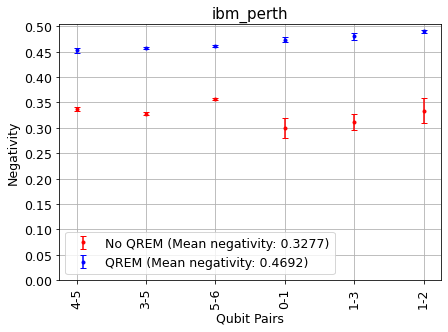

In [138]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibmq_guadalupe

In [14]:
backend = provider.get_backend('ibmq_guadalupe')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_guadalupe (16 qubits)
Job 1 ID: 62e762a215d03377cc49967b
Job 2 ID: 62e762b922b5f5d8cd568004


In [139]:
time0 = time()
backend = provider.get_backend('ibmq_guadalupe')
job1 = backend.retrieve_job('62e762a215d03377cc49967b')
job2 = backend.retrieve_job('62e762b922b5f5d8cd568004')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 50.05 s


{'Mean negativity': 0.30179741101882496,
 'std': 0.026119732460266734,
 'Mean negativity (mit)': 0.4238520074096368,
 'std (mit)': 0.031777337821183686,
 'Connected N>5%': 16,
 'Connected N>50%': 16,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 16,
 'Connected N>50% (mit)': 16,
 'Connected N>75% (mit)': 16,
 'Connected N>90% (mit)': 3}

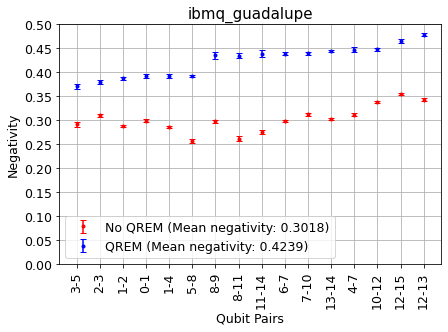

In [140]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibmq_toronto

In [18]:
backend = provider.get_backend('ibmq_toronto')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_toronto (27 qubits)
Job 1 ID: 62e007f6a4cdd20758511302
Job 2 ID: 62e008097b5403fa682dcd0a


In [141]:
time0 = time()
backend = provider.get_backend('ibmq_toronto')
job1 = backend.retrieve_job('62e007f6a4cdd20758511302')
job2 = backend.retrieve_job('62e008097b5403fa682dcd0a')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 118.00 s


{'Mean negativity': 0.17787640740764538,
 'std': 0.12116324842379912,
 'Mean negativity (mit)': 0.34853085163152064,
 'std (mit)': 0.0984641505684214,
 'Connected N>5%': 26,
 'Connected N>50%': 7,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 18,
 'Connected N>75% (mit)': 7,
 'Connected N>90% (mit)': 2}

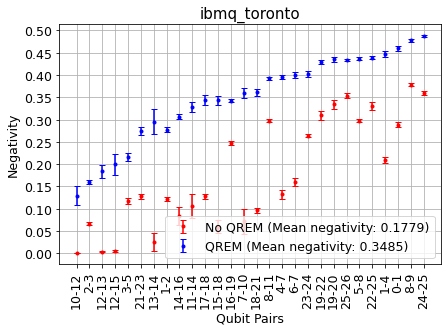

In [142]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_geneva

In [11]:
backend = provider.get_backend('ibm_geneva')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_geneva (27 qubits)
Job 1 ID: 62e1d476fb9fa11a0da32153
Job 2 ID: 62e1d48bc12764f4277eb995


In [143]:
time0 = time()
backend = provider.get_backend('ibm_geneva')
job1 = backend.retrieve_job('62e1d476fb9fa11a0da32153')
job2 = backend.retrieve_job('62e1d48bc12764f4277eb995')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 109.92 s


{'Mean negativity': 0.20977691837617238,
 'std': 0.11392557413819648,
 'Mean negativity (mit)': 0.4355681045241782,
 'std (mit)': 0.10181661781865747,
 'Connected N>5%': 19,
 'Connected N>50%': 8,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 26,
 'Connected N>75% (mit)': 26,
 'Connected N>90% (mit)': 16}

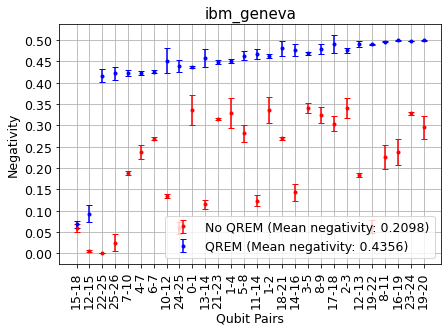

In [144]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_hanoi

In [13]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_hanoi (27 qubits)
Job 1 ID: 62debb30a7255f2ce80560da
Job 2 ID: 62debb76e52ec50930ce06a5


In [145]:
time0 = time()
backend = provider.get_backend('ibm_hanoi')
job1 = backend.retrieve_job('62debb30a7255f2ce80560da')
job2 = backend.retrieve_job('62debb76e52ec50930ce06a5')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 118.16 s


{'Mean negativity': 0.2950134496781517,
 'std': 0.07735673274927238,
 'Mean negativity (mit)': 0.44421814506462576,
 'std (mit)': 0.029110890047381155,
 'Connected N>5%': 27,
 'Connected N>50%': 12,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 7}

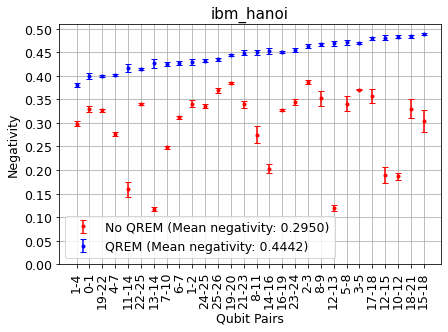

In [146]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_auckland

In [3]:
backend = provider.get_backend('ibm_auckland')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_auckland (27 qubits)
Job 1 ID: 62e0b39822b5f585165658b4
Job 2 ID: 62e0b3b2c2d497736fe36c1d


In [147]:
time0 = time()
backend = provider.get_backend('ibm_auckland')
job1 = backend.retrieve_job('62e0b39822b5f585165658b4')
job2 = backend.retrieve_job('62e0b3b2c2d497736fe36c1d')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 125.31 s


{'Mean negativity': 0.34828670996935784,
 'std': 0.06526265873775461,
 'Mean negativity (mit)': 0.41160042851359274,
 'std (mit)': 0.06140131182300528,
 'Connected N>5%': 27,
 'Connected N>50%': 26,
 'Connected N>75%': 6,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 26,
 'Connected N>75% (mit)': 20,
 'Connected N>90% (mit)': 3}

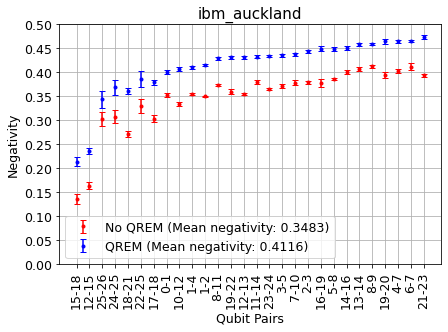

In [148]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_cairo

In [16]:
backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_cairo (27 qubits)
Job 1 ID: 62e006f6d5e93a5b6263784c
Job 2 ID: 62e007079ef051fa937697c1


In [149]:
time0 = time()
backend = provider.get_backend('ibm_cairo')
job1 = backend.retrieve_job('62e006f6d5e93a5b6263784c')
job2 = backend.retrieve_job('62e007079ef051fa937697c1')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 121.73 s


{'Mean negativity': 0.33508399654539556,
 'std': 0.041348855016684484,
 'Mean negativity (mit)': 0.43662632230966053,
 'std (mit)': 0.031239098478031774,
 'Connected N>5%': 27,
 'Connected N>50%': 26,
 'Connected N>75%': 4,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 27,
 'Connected N>90% (mit)': 5}

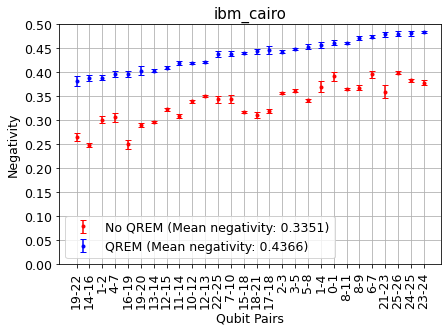

In [150]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())
info_dict

#### ibmq_mumbai

In [17]:
backend = provider.get_backend('ibmq_mumbai')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_mumbai (27 qubits)
Job 1 ID: 62e007759ef05199917697d7
Job 2 ID: 62e0078aa7255f3449056904


In [151]:
time0 = time()
backend = provider.get_backend('ibmq_mumbai')
job1 = backend.retrieve_job('62e007759ef05199917697d7')
job2 = backend.retrieve_job('62e0078aa7255f3449056904')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 116.83 s


{'Mean negativity': 0.2796978908771755,
 'std': 0.08283458758254277,
 'Mean negativity (mit)': 0.4409387618189221,
 'std (mit)': 0.0825746222972075,
 'Connected N>5%': 27,
 'Connected N>50%': 21,
 'Connected N>75%': 2,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 24,
 'Connected N>90% (mit)': 19}

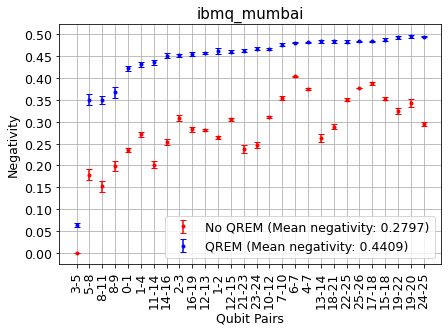

In [152]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibmq_montreal

In [ ]:
backend = provider.get_backend('ibmq_montreal')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibmq_montreal (27 qubits)
Job 1 ID: 62e006677b5403911c2dccef
Job 2 ID: 62e0067d1813982307c6d2c3


In [153]:
time0 = time()
backend = provider.get_backend('ibmq_montreal')
job1 = backend.retrieve_job('62e006677b5403911c2dccef')
job2 = backend.retrieve_job('62e0067d1813982307c6d2c3')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 109.87 s


{'Mean negativity': 0.210502864185184,
 'std': 0.06385402077053111,
 'Mean negativity (mit)': 0.39388774761452444,
 'std (mit)': 0.054224599003013796,
 'Connected N>5%': 27,
 'Connected N>50%': 5,
 'Connected N>75%': 0,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 27,
 'Connected N>75% (mit)': 18,
 'Connected N>90% (mit)': 3}

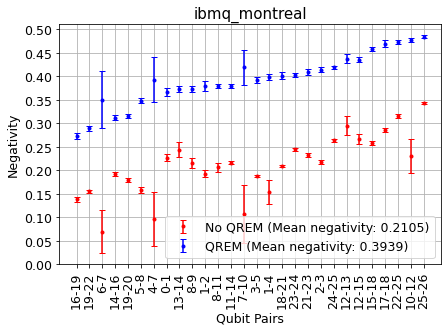

In [154]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

Qubit 7 had an anomously high readout error 3.265e-1 (mean 4.129e-2)

#### ibmq_kolkata

In [ ]:
backend = provider.get_backend('ibmq_kolkata')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

In [155]:
time0 = time()
backend = provider.get_backend('ibmq_kolkata')
job1 = backend.retrieve_job('62e0b33b5593a82bd1192732')
job2 = backend.retrieve_job('62e0b3558fc097738f0a8655')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 130.80 s


{'Mean negativity': 0.3155555107567946,
 'std': 0.11961782273267371,
 'Mean negativity (mit)': 0.3898073211050471,
 'std (mit)': 0.136842968764913,
 'Connected N>5%': 27,
 'Connected N>50%': 23,
 'Connected N>75%': 8,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 27,
 'Connected N>50% (mit)': 24,
 'Connected N>75% (mit)': 11,
 'Connected N>90% (mit)': 11}

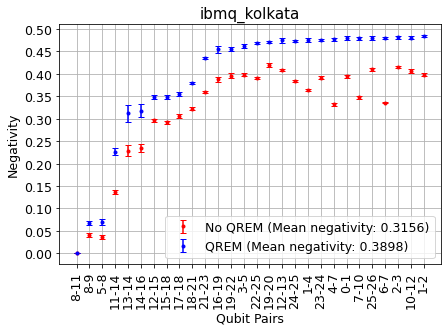

In [156]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

fig = plot_negativities_multi(backend, n_list, nmit_list)
fig.tight_layout()
fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

#### ibm_washington

In [4]:
backend = provider.get_backend('ibm_washington')
graphstate = GraphState(backend)
job1 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=4, shots=8192, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())

Device: ibm_washington (127 qubits)
Job 1 ID: 639111ce44034d30fd4d48eb
Job 2 ID: 6391122dd65d0d426a038369


In [5]:
time0 = time()
backend = provider.get_backend('ibm_washington')
#job1 = backend.retrieve_job('630bf9359877ca68932a4cc7')
#job2 = backend.retrieve_job('630bf9d56d08101c02db5117')
#job1 = backend.retrieve_job('62f9b8033eae6d60a8d3b1ce')
#job2 = backend.retrieve_job('62f9b888d7bba196db87a916')

#job1 = backend.retrieve_job('62e7633bac90f75e39c85ceb')
#job2 = backend.retrieve_job('62e763a015d033aaad49968a')

graphstate = GraphState(backend)
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 1786.94 s


{'Mean negativity': 0.28986728246175575,
 'std': 0.11681760258478067,
 'Mean negativity (mit)': 0.40787949441444904,
 'std (mit)': 0.10223922605510437,
 'Connected N>5%': 121,
 'Connected N>50%': 85,
 'Connected N>75%': 6,
 'Connected N>90%': 0,
 'Connected N>5% (mit)': 127,
 'Connected N>50% (mit)': 115,
 'Connected N>75% (mit)': 90,
 'Connected N>90% (mit)': 43}

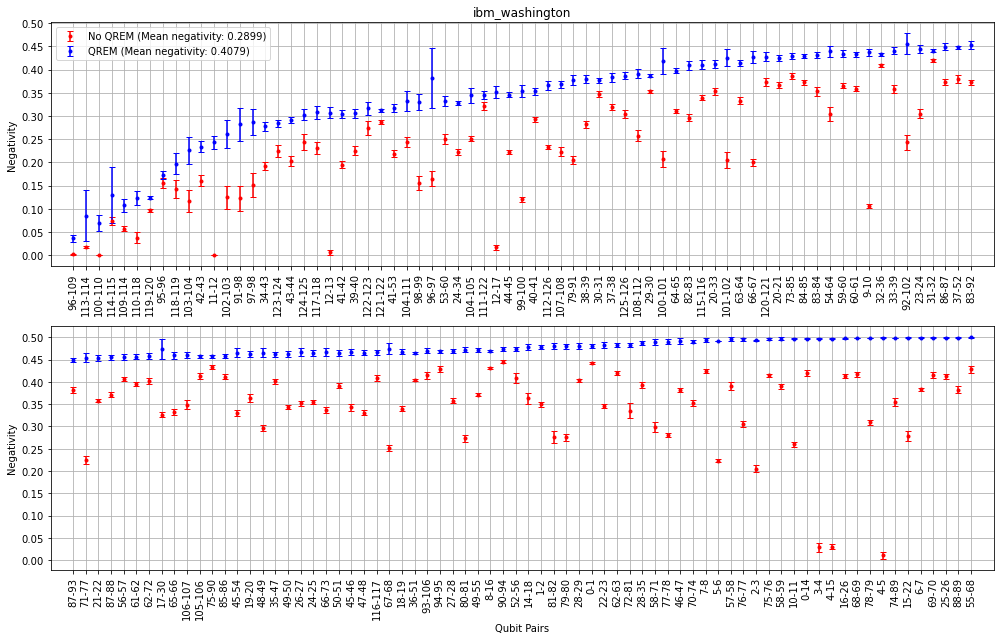

In [6]:
n_list1 = calc_negativities(rho_dict1, mode='max')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='max')
n_list2 = calc_negativities(rho_dict2, mode='max')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='max')
n_list = n_list1 + n_list2
nmit_list = nmit_list1 + nmit_list2

#fig = plot_negativities_multi(backend, n_list, nmit_list, figsize=(21, 7))
#fig.tight_layout()
#fig.savefig(f'output/negativities/{backend.name()}_negativities', dpi=300)

fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 9))

edges = n_list[0].keys()
n_mean, n_std = calc_n_mean(n_list)

# Convert into array for plotting
X = np.array([f'{edge[0]}-{edge[1]}' for edge in edges])
Y0 = np.fromiter(n_mean.values(), float)
Y0err = np.fromiter(n_std.values(), float)

# If mitigated results are included
nmit_mean, nmit_std = calc_n_mean(nmit_list)

Y1 = np.fromiter(nmit_mean.values(), float)
Y1err = np.fromiter(nmit_std.values(), float)
# Order in increasing minimum negativity (QREM)
Y1min = Y1 - Y1err
idx = Y1min.argsort()
Y1 = Y1[idx]
Y1err = Y1err[idx]

X = X[idx]
Y0 = Y0[idx]
Y0err = Y0err[idx]

hp = int(len(X)/2)

ax1.errorbar(X[:hp], Y0[:hp], yerr=Y0err[:hp], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax1.errorbar(X[:hp], Y1[:hp], yerr=Y1err[:hp], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

ax2.errorbar(X[hp:], Y0[hp:], yerr=Y0err[hp:], capsize=3, fmt='.', c='r', 
            label=f'No QREM (Mean negativity: {np.mean(Y0):.4f})')

ax2.errorbar(X[hp:], Y1[hp:], yerr=Y1err[hp:], capsize=3, fmt='.', c='b', 
            label=f'QREM (Mean negativity: {np.mean(Y1):.4f})')

for ax in (ax1, ax2):
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid()
    ax.set_ylabel("Negativity")
    ax.margins(0.025, 0.05)
    
ax1.legend()
ax2.set_xlabel("Qubit Pairs")
ax1.set_title(backend.name())
fig.set_tight_layout(True)

fig.savefig('output/negativities/ibm_washington_negativities', dpi=300)

info_dict = get_negativity_info(n_list, nmit_list)
m, s = get_mean_cnot(graphstate, job1.properties())

n_mean_list.append(info_dict['Mean negativity'])
n_std_list.append(info_dict['std'])
nmit_mean_list.append(info_dict['Mean negativity (mit)'])
nmit_std_list.append(info_dict['std (mit)'])
err_mean.append(m)
err_std.append(s)
device.append(backend.name())

info_dict

In [51]:
n_dicts = dict.fromkeys(n_dict)
for k, v in n_dicts.items():
    n_dicts[k] = []
    
for i in range(len(n_list)):
    for k in n_dicts.keys():
        #print(k)
        n_dicts[k].append(n_list[i][k])

In [52]:
nmit_dicts = dict.fromkeys(n_dict)
for k, v in nmit_dicts.items():
    nmit_dicts[k] = []
    
for i in range(len(nmit_list)):
    for k in nmit_dicts.keys():
        #print(k)
        nmit_dicts[k].append(nmit_list[i][k])

In [58]:
import csv

with open('output/neg.csv', 'w', newline='') as f:
    w = csv.writer(f)
    for k, v in n_dicts.items():
        w.writerow([k] + v)
        
with open('output/neg_qrem.csv', 'w', newline='') as f:
    w = csv.writer(f)
    for k, v in nmit_dicts.items():
        w.writerow([k] + v)

#### Negativity Map

In [59]:
import matplotlib as mpl
from qiskit.visualization import plot_gate_map, plot_coupling_map
from qubit_coords import qubit_coords127

plt.rc('font', size=13)

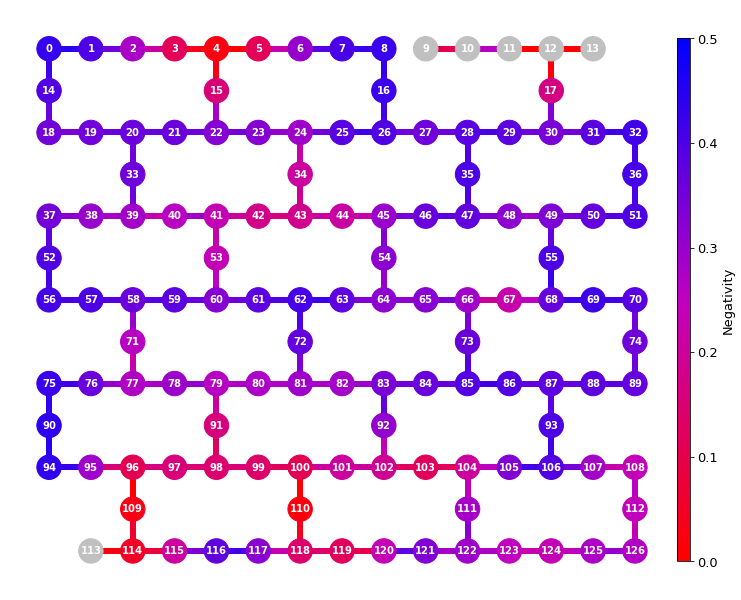

In [60]:
nqubits = 127
#n_dict = nmit_mean
n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/ghznmap127.png', dpi=400)

fig

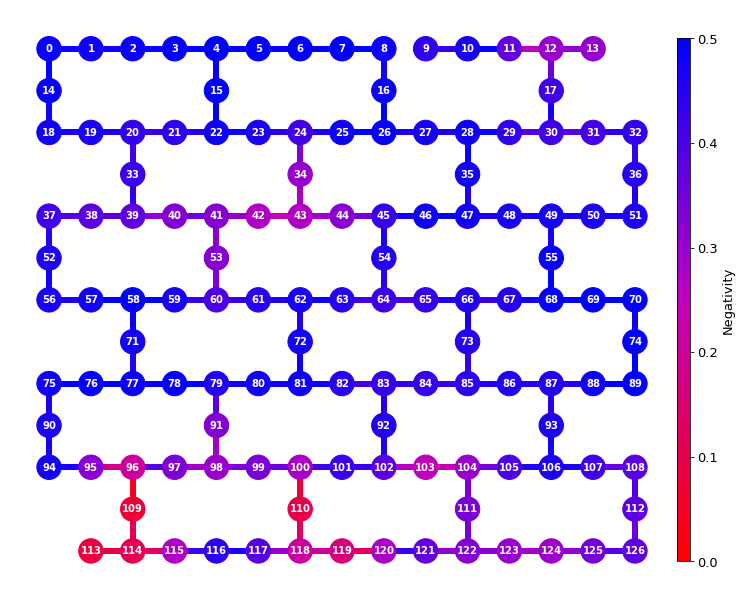

In [61]:
nqubits = 127
n_dict = nmit_mean
#n_dict = n_mean

cmap = mpl.cm.get_cmap('RdBu')
cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['r', 'm', 'b'])
#cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",['tab:red', 'tab:purple', 'tab:blue'])

edges = filter_edges(n_dict, threshold=0.025)
G = nx.Graph()
G.add_edges_from(edges)
unconnected = list(set(range(127)) - list(nx.connected_components(G))[0])

qubit_n = np.zeros(nqubits)
qubit_color = []
edge_list = []
line_color = []

for key, values in n_dict.items():
    edge_list.append(key)
    line_color.append(mpl.colors.to_hex(cmap(2*values), keep_alpha=True))
    qubit_n[key[0]] += values
    qubit_n[key[1]] += values
    
for i, n in enumerate(qubit_n):
    x = 2*n/graphstate.graph.degree[i]
    if i in unconnected:
        #qubit_color.append('#D3D3D3')
        qubit_color.append('#C0C0C0')
    else:
        qubit_color.append(mpl.colors.to_hex(cmap(x), keep_alpha=True))

fig = plot_coupling_map(nqubits, qubit_coords127, edge_list, line_color=line_color, qubit_color=qubit_color,
                        line_width=6, figsize=(12,12))

norm = mpl.colors.Normalize(vmin=0, vmax=0.5)

ax = fig.get_axes()[0]
cax = fig.add_axes([0.9, 0.2, 0.015, 0.605])

im = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(im, cax=cax, orientation='vertical', label='Negativity')
fig.savefig('output/ghznmitmap127.png', dpi=400)

fig

## Negativity Correlations

In [162]:
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr


n_mean = calc_n_mean(n_list)
nmit_mean = calc_n_mean(nmit_list)
properties = job1.properties()
adj_edges = graphstate.adj_edges

n_meanf = {}
nmit_meanf = {}
edges = n_mean[0].keys()
for edge in edges:
    err = properties.gate_error('cx', edge)
    if err < 0.1:
        n_meanf[edge] = n_mean[0][edge]
        nmit_meanf[edge] = nmit_mean[0][edge]

#fig1a = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=False)
X, Y0 = plot_cxerr_corr(properties, adj_edges, n_meanf, inc_adj=True)
#fig2a = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=False)
X, Y1 = plot_cxerr_corr(properties, adj_edges, nmit_meanf, inc_adj=True)

c0, m0 = polyfit(X, Y0, 1)
c1, m1 = polyfit(X, Y1, 1)
Xfit = np.linspace(min(X), max(X), 100)

corr0, _ = pearsonr(X, Y0)
corr1, _ = pearsonr(X, Y1)

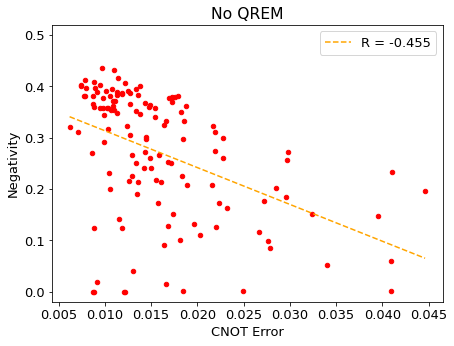

In [163]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6.5, 5))
ax.scatter(X, Y0, color='red', s=20)
ax.plot(Xfit, m0*Xfit+c0, ls='--', color='orange', label=f'R = {corr0:.3f}')

ax.set_title('No QREM')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend(loc=1)
ax.set_ylim(-0.02, 0.52)

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation1', dpi=300)

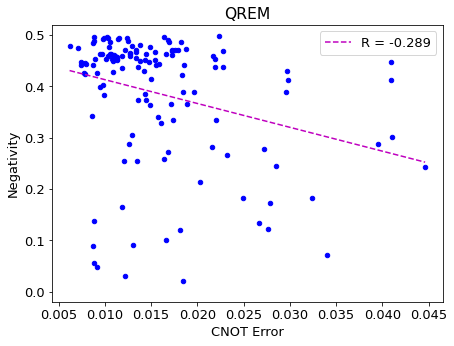

In [164]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6.5, 5))
ax.scatter(X, Y1, color='b', s=20)
ax.plot(Xfit, m1*Xfit+c1, ls='--', color='m', label=f'R = {corr1:.3f}')

ax.set_title('QREM')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend(loc=1)
ax.set_ylim(-0.02, 0.52)

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation2', dpi=300)

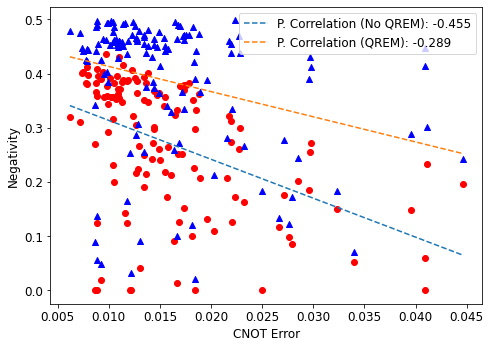

In [93]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X, Y0, marker='o', color='r')
ax.plot(Xfit, m0*Xfit+c0, ls='--', label=f'P. Correlation (No QREM): {corr0:.3f}')
ax.scatter(X, Y1, marker='^', color='b')
ax.plot(Xfit, m1*Xfit+c1, ls='--', label=f'P. Correlation (QREM): {corr1:.3f}')

ax.set_ylabel('Negativity')
ax.set_xlabel('CNOT Error')

ax.legend()
#ax.legend(loc=1)

fig.set_tight_layout(True)
#fig.savefig('output/negativitycorrelation', dpi=300)

In [77]:
from numpy.polynomial.polynomial import polyfit
from scipy.stats import pearsonr
import numpy as np

c0, m0 = polyfit(err_mean, n_mean_list, 1)
c1, m1 = polyfit(err_mean, nmit_mean_list, 1)
Xfit = np.linspace(min(err_mean), max(err_mean), 100)

corr0, _ = pearsonr(err_mean, n_mean_list)
corr1, _ = pearsonr(err_mean, nmit_mean_list)

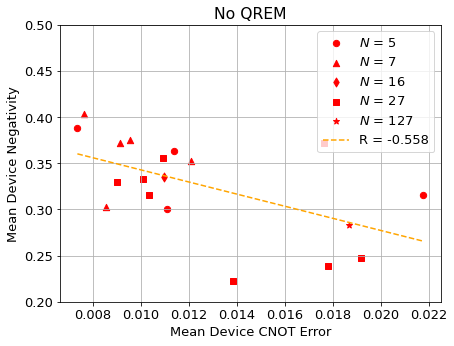

In [99]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6.5, 5))
s = 40
ax.scatter(err_mean[:4], n_mean_list[:4], marker='o', color='r', s=s, label='$\it{N}$ = 5')
ax.scatter(err_mean[4:9], n_mean_list[4:9], marker='^', color='r', s=s, label='$\it{N}$ = 7')
ax.scatter(err_mean[9], n_mean_list[9], marker='d', color='r', s=s, label='$\it{N}$ = 16')
ax.scatter(err_mean[10:18], n_mean_list[10:18], marker='s', color='r', s=s, label='$\it{N}$ = 27')
ax.scatter(err_mean[18], n_mean_list[18], marker='*', color='r', s=s, label='$\it{N}$ = 127')
ax.plot(Xfit, m0*Xfit+c0, ls='--', color='orange', label=f'R = {corr0:.3f}')

ax.set_ylim(0.2, 0.5)

ax.set_ylabel('Mean Device Negativity')
ax.set_xlabel('Mean Device CNOT Error')
ax.set_title('No QREM')

ax.legend(loc=1)
ax.grid()

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation3', dpi=300)

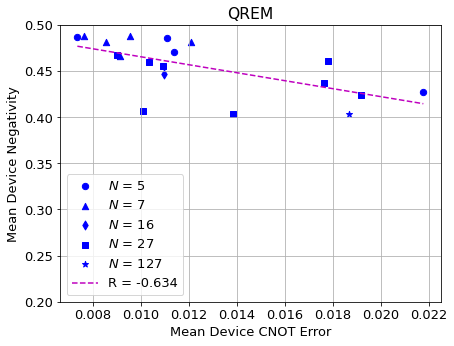

In [100]:
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6.5, 5))
s = 40
ax.scatter(err_mean[:4], nmit_mean_list[:4], marker='o', color='b', s=s, label='$\it{N}$ = 5')
#ax.errorbar(err_mean[:4], nmit_mean_list[:4], nmit_std_list[:4], err_std[:4], marker='o', color='b', markersize=3, label='$\it{N}$ = 5', ls='')
ax.scatter(err_mean[4:9], nmit_mean_list[4:9], marker='^', color='b', s=s, label='$\it{N}$ = 7')
ax.scatter(err_mean[9], nmit_mean_list[9], marker='d', color='b', s=s, label='$\it{N}$ = 16')
ax.scatter(err_mean[10:18], nmit_mean_list[10:18], marker='s', color='b', s=s, label='$\it{N}$ = 27')
ax.scatter(err_mean[18], nmit_mean_list[18], marker='*', color='b', s=s, label='$\it{N}$ = 127')
ax.plot(Xfit, m1*Xfit+c1, ls='--', color='m', label=f'R = {corr1:.3f}')

ax.set_ylim(0.2, 0.5)

ax.set_ylabel('Mean Device Negativity')
ax.set_xlabel('Mean Device CNOT Error')
ax.set_title('QREM')

ax.legend()
ax.grid()

fig.set_tight_layout(True)
fig.savefig('output/negativitycorrelation4', dpi=300)